In [1]:
from models import *
import pandas as pd
import numpy as np
import tensorflow as tf
import shutil
import os
print("Tensorflow version: ", tf.__version__)

excel_reports = ".\Excel reports"
saved_models = ".\Saved models"
trained_models = ".\Trained models"

# Initiate parameters
ticker = 'mrk'
period = "1wk"

sentiment = True
# Sentiment types...
# APISentiment	VaderSentiment	CombinedVaderSentiment RobertaLargeSentiment #TwitterSentiment
sentiment_type = 'CombinedVaderSentiment'
aggr_function = 'median'

formation_window = 24
target_window = 4

split_ratio = 0.80

# Do not change
window_size = formation_window + 1

if sentiment == False:
    news_df = None
if sentiment_type == 'TwitterSentiment':
    twitter = True
else:
    twitter = False
    
# Print stuffs
print("\nwindow size: ", window_size)
print("formation_window: ", formation_window)
print("target_window: ", target_window)
print("chart period: ", period)

# training batches
batch_size_train = 16
batch_size_valid = 4

# Period model is trained and tested
start_date = '2020-01-01'  # ''2020-01-01   2015-01-01
end_date = '2022-09-24'  # '' 2022-08-17

# #Delete folders
shutil.rmtree(excel_reports)
shutil.rmtree(saved_models)
shutil.rmtree(trained_models)

# Create folder, if exist pass exception
try:
    os.mkdir("Excel reports")
    os.mkdir("Saved models")
    os.mkdir("Trained models")
except:
    pass


Tensorflow version:  2.9.1

window size:  25
formation_window:  24
target_window:  4
chart period:  1wk


In [2]:
if sentiment == True:

    from sentiment import GetNews

    GetNewsAPI = GetNews()

    api_key = ''

    GetNewsAPI.fit(ticker=ticker, start_date=start_date, end_date=end_date,
                   n_news=1000, token=api_key, offset=0, export_excel=True, twitter=twitter)
    news_df = GetNewsAPI.transform()
news_df


c:\Users\z0040jeb\Desktop\MachineLearning\Data Science\VSCode\04_StockPrediction\04_stockprediction\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\z0040jeb\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\z0040jeb\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


--------> GetNews completed



,Date,Title,Content,APISentiment,VaderSentiment,CombinedVaderSentiment
0,2022-09-24,"A Stock's Price ""Tells You Almost Nothing""","Last time we played The Market Cap Game Show, ...",0.671,0.0000,0.6710
1,2022-09-24,Merck (NYSE:MRK) shareholders have earned a 11...,"If you buy and hold a stock for many years, yo...",0.999,0.0000,0.9990
2,2022-09-23,Merck's (MRK) Stock Up on Januvia Patent Win A...,Merck’s MRK stock was up 3.5% on Thursday afte...,0.977,0.5859,1.5629
3,2022-09-23,Pharma Stock Roundup: EU Nod to AZN &amp; RHHB...,"This week, the European Commission (EC) grante...",0.997,0.0000,0.9970
4,2022-09-23,10 Most Shorted Stocks in September,"In this article, we discuss the 10 most shorte...",0.994,0.0000,0.9940
...,...,...,...,...,...,...
985,2021-12-19,Pioneer VCT Fund Buys Live Nation Entertainmen...,Investment company Pioneer VCT Fund (Current P...,0.995,0.4215,1.4165
986,2021-12-17,Variable Portfolio - Partners International Gr...,Investment company Variable Portfolio - Partne...,0.998,0.3818,1.3798
987,2021-12-17,Portfolio manager breaks down market worries o...,"John Petrides, portfolio manager at Tocquevill...",-0.077,-0.4215,-0.4985
988,2021-12-17,BioInvent announces positive early data from o...,"LUND, SE / ACCESSWIRE / December 17, 2021 / Bi...",0.972,-0.0516,0.9204


In [3]:
from transformers_preprocess import PullData

GetData = PullData()

GetData.fit(ticker=ticker,
            start_date=start_date,
            end_date=end_date,
            interval=period,  # 1wk
            progress=False,
            condition=False,
            form_window=formation_window,
            target_window=target_window,
            timeperiod1=6,
            timeperiod2=12,
            timeperiod3=24,
            export_excel=True,
            excel_path=excel_reports,
            listed_conditions=None,
            sentiment=sentiment,
            sentiment_type=sentiment_type, #sentiment_type
            news_df=news_df,
            chart_period=period,
            sentiment_aggr=aggr_function)

data_prep = GetData.transform()

# Validation
if window_size != (formation_window + 1):
    raise Exception(
        f"Error - window_size ({window_size}) must be equal to sum of formation_window ({formation_window}) and value 1.")
data_prep.head()


initial shape:  (151, 6)
Output shape:  (2900, 10)
--------> PullData completed



,Date,Open,High,Low,Close,EMA6,EMA12,EMA24,CombinedVaderSentiment,trades
0,2019-12-30 00:00:00,86.755722,87.919846,86.230919,87.070610,84.009224,79.525286,77.328642,0.0,1
1,2020-01-06 00:00:00,87.051529,87.538170,84.360687,85.429390,84.009224,79.525286,77.328642,0.0,1
2,2020-01-13 00:00:00,85.419846,87.843513,84.799622,86.803436,84.009224,79.525286,77.328642,0.0,1
3,2020-01-20 00:00:00,86.564888,86.803436,81.660301,82.041985,84.009224,79.525286,77.328642,0.0,1
4,2020-01-27 00:00:00,81.202293,84.122139,80.830154,81.526718,84.009224,79.525286,77.328642,0.0,1


In [4]:
####################################################################

from transformers_preprocess import NormalizeData

NormalizeData = NormalizeData()

NormalizeData.fit(window_size=window_size, shuffle=False, debug=False,
                  export_excel=True, excel_path=excel_reports, sentiment=sentiment)

data_normalized, Dates = NormalizeData.transform(data_prep)
data_normalized.head()
# Get only forecasts for model testing
# x_valid_x = data_normalized[['maxv','minv']].copy() #extreme values for reverting normalization
# x_valid = data_normalized.iloc[:,:-2].copy() #dataset for forecast


Dataframe shape:  (2900, 10)
Number of formations:  116
--------> NormalizeData completed



,Open,High,Low,Close,EMA6,EMA12,EMA24,CombinedVaderSentiment,maxv,minv
0,0.954630,1.000000,0.934176,0.966902,0.847589,0.672834,0.587223,0.0,87.919846,62.261452
1,0.966159,0.985125,0.861287,0.902938,0.847589,0.672834,0.587223,0.0,87.919846,62.261452
2,0.902566,0.997025,0.878394,0.956490,0.847589,0.672834,0.587223,0.0,87.919846,62.261452
3,0.947192,0.956490,0.756043,0.770919,0.847589,0.672834,0.587223,0.0,87.919846,62.261452
4,0.738193,0.851990,0.723689,0.750837,0.847589,0.672834,0.587223,0.0,87.919846,62.261452


In [5]:
####################################################################

from training import SplitData

SplitData = SplitData()

SplitData.fit(split_ratio=split_ratio, window_size=window_size,
              dates=Dates, debug=False, export_excel=True, excel_path=excel_reports, sentiment=sentiment)

x_train, x_valid, x_train_x, x_valid_x = SplitData.transform(data_normalized)
# x_train.head(25)



Split ratio: 80 %
train period: 2019-12-30 - 2022-03-14
valid period: 2021-10-11 - 2022-08-22
x_train window:  93.0
x_valid window:  23.0
--------> SplitData completed



In [6]:
from training import GetTensoredDataset

GetTensoredDataset = GetTensoredDataset()

GetTensoredDataset.fit(window_size=window_size, batch_size=batch_size_train, train=True, debug=False)

x_train_tensors, _ = GetTensoredDataset.transform(x_train)

# c = 0
# for batch in x_train_tensors:
#     if c < 3:
#         print(batch)
#     else:
#         break

--------> GetTensoredDataset completed



In [7]:
from training import GetTensoredDataset

GetTensoredValidDataset = GetTensoredDataset()

GetTensoredValidDataset.fit(
    window_size=window_size, batch_size=batch_size_valid, train=False, debug=False)

x_valid_tensors, labels = GetTensoredValidDataset.transform(x_valid)

# for batch in x_valid_tensors:
#     if c < 3:
#         print(batch)
#     else:
#         break

--------> GetTensoredDataset completed



<b>Model Training</b>

In [8]:
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.callbacks import ModelCheckpoint


model_name = f'{saved_models}/{str.upper(ticker)}_{formation_window}_{target_window}_{window_size}_{split_ratio}_{period}_{sentiment}_{start_date}_{end_date}.h5'

early_stopping = EarlyStopping(
    monitor='val_loss', patience=6, mode='min', restore_best_weights=True)

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                              patience=2, min_lr=10e-15,
                              verbose=0)

model_checkpoint = ModelCheckpoint(monitor='val_loss',
                                   filepath=model_name,
                                   save_best_only=True)

callbacks = [early_stopping, reduce_lr, model_checkpoint]


def sign_penalty(y_true, y_pred):
    penalty = 100.
    loss = tf.where(tf.less(y_true*y_pred, 0),
                    penalty * tf.square(y_true-y_pred),
                    tf.square(y_true - y_pred)
                    )

    return(tf.reduce_mean(loss, axis=-1))


tf.keras.losses.sign_penalty = sign_penalty


Bellow code is used to find the best model architecture, recommended to use cloud computing

In [9]:
now = datetime.now()
now = now.strftime("%d%m%Y %H%M%S")
now

NameError: name 'datetime' is not defined

In [12]:
# from datetime import datetime
# start_time = datetime.now().strftime("%H:%M:%S")
# print("started at ",start_time)

# # #Permutation testing
# # num_layers = 2
# # min, max = 2, 4
# # node_step_size = 2
# # node_options = list(range(min, max + 1, node_step_size))
# # two_layer_possibilities = [node_options, node_options]
# # layer_node_permutations  = list(itertools.product(*two_layer_possibilities))

# from testing import *
# f_df = pd.DataFrame()

# for layer in range(3,4):
#     print("------ > Layer: ",layer)
#     all_models = get_models(lstm_included=True,num_layers=layer, min=2, max=4, node_step_size=1, features=x_train.shape[1])
#     optimizing_df = optimize(models=all_models,X_train=x_train_tensors,X_valid=x_valid_tensors,X_test=x_valid,labels=labels,epochs=1000,verbose=0,window_size=window_size,callbacks=callbacks,layer=layer,ticker=ticker)
# # optimizing_df
#     f_df = f_df.append(optimizing_df)
# current_time = datetime.now().strftime("%H:%M:%S")
# print("ended at ",current_time)
# f_df

Get Model

In [51]:
tf.random.set_seed(7788)
np.random.seed(7788)

features = x_train.shape[1]
print(f"Model training - {str.upper(ticker)} \n")

#model = clb_model(features)
#model = mrk_model(features)
model =  mrk_model_sent_medium(features)

# model = tf.keras.models.Sequential([

#         tf.keras.layers.Conv1D(filters=4, kernel_size=10,
#                                strides=1, padding="same",
#                                activation=tf.nn.selu,
#                                input_shape=[None, features]),
#         tf.keras.layers.Bidirectional(
#             tf.keras.layers.LSTM(3, return_sequences=True)),
#         tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(3)),
#         tf.keras.layers.Dense(2, activation=tf.nn.selu),
#         tf.keras.layers.Dense(2, activation=tf.nn.selu),
#         tf.keras.layers.Dense(1, activation=tf.nn.relu),
#     ])


optimizer2 = tf.keras.optimizers.Adam(
        learning_rate=0.0009, beta_1=0.9, beta_2=0.999, epsilon=1e-07, amsgrad=False)
optimizer5 = tf.keras.optimizers.Adagrad(
    learning_rate=0.005, initial_accumulator_value=5, epsilon=1e-07, name='Adagrad')

model.compile(loss=sign_penalty,
              optimizer=optimizer2,
              )

model.fit(x_train_tensors, epochs=1200, callbacks=[
          callbacks], validation_data=x_valid_tensors,verbose=1)
#model.summary()


Model training - MRK 

Epoch 1/1200
6/6 [==============================] - 12s 525ms/step - loss: 0.1529 - val_loss: 0.5991 - lr: 9.0000e-04
Epoch 2/1200
6/6 [==============================] - 0s 43ms/step - loss: 0.0946 - val_loss: 0.2009 - lr: 9.0000e-04
Epoch 3/1200
6/6 [==============================] - 0s 43ms/step - loss: 0.0943 - val_loss: 0.1052 - lr: 9.0000e-04
Epoch 4/1200
6/6 [==============================] - 0s 59ms/step - loss: 0.0467 - val_loss: 0.0314 - lr: 9.0000e-04
Epoch 5/1200
6/6 [==============================] - 0s 61ms/step - loss: 0.0405 - val_loss: 0.0085 - lr: 9.0000e-04
Epoch 6/1200
6/6 [==============================] - 0s 63ms/step - loss: 0.0371 - val_loss: 0.0077 - lr: 9.0000e-04
Epoch 7/1200
6/6 [==============================] - 0s 43ms/step - loss: 0.0310 - val_loss: 0.0165 - lr: 9.0000e-04
Epoch 8/1200
6/6 [==============================] - 0s 42ms/step - loss: 0.0293 - val_loss: 0.0225 - lr: 9.0000e-04
Epoch 9/1200
6/6 [=============================

In [52]:
def model_forecast(model, series, window_size, debug):
    """
    Get model, data and window size as an input. 
    Make prediction window is subtracted by 1, since we do not need label in window, 
    label value is skipped
    """
    c = 0

    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size-1, shift=window_size, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))

    if debug == True:
        # This block of code will print out data on which is made prediction
        for item in ds:
            c += 1
            if c < 3:
                print("\n"+str(c) + " prediction:\n ", item)
            else:
                break

    ds = ds.batch(1).prefetch(1)
    forecast = model.predict(ds)
    forecast2 = np.squeeze(forecast)
    return forecast2


forecast = model_forecast(model, x_valid, window_size=window_size, debug=False)
forecast


23/23 [==============================] - 2s 7ms/step


array([0.86891264, 0.8918232 , 0.9335875 , 1.0084566 , 1.0543727 ,
       1.0544081 , 1.0220346 , 0.96222657, 0.9085277 , 0.85843164,
       0.88866526, 0.8843477 , 0.8532554 , 0.856319  , 0.8661297 ,
       0.8697327 , 0.88160855, 0.87520343, 0.83944994, 0.8134547 ,
       0.8070745 , 0.8338292 , 0.8311092 ], dtype=float32)

In [53]:
# pr = x_valid.iloc[:24, :].to_numpy()
# pr = np.array([pr])
# pr = np.array([pr])
# pred = tf.data.Dataset.from_tensor_slices(pr)

In [54]:
from transformers_preprocess import ReverseNormalization

ReverseNormalization = ReverseNormalization()

ReverseNormalization.fit(forecasts=forecast, labels=labels,
                         x_valid=x_valid, x_valid_x=x_valid_x, window_size=window_size, debug=False,
                         sentiment=sentiment,sentiment_type=sentiment_type)

df = ReverseNormalization.transform()
df.head(25)

--------> ReverseNormalization completed



,Open,High,Low,Close,EMA6,EMA12,EMA24,labels,prediction,CombinedVaderSentiment
In,,,,,,,,,,
0,81.639999,81.639999,77.980003,78.330002,77.834209,77.100902,76.448361,NaN,NaN,0.00000
1,78.739998,81.480003,77.110001,81.150002,78.781578,77.723840,76.824492,NaN,NaN,0.00000
2,81.029999,88.459999,79.949997,88.050003,81.429699,79.312481,77.722533,NaN,NaN,0.00000
3,88.050003,91.400002,81.349998,81.610001,81.481214,79.665945,78.033530,NaN,NaN,0.00000
4,80.410004,84.260002,79.879997,84.000000,82.200867,80.332723,78.510848,NaN,NaN,0.00000
5,84.150002,84.690002,80.620003,80.699997,81.772047,80.389227,78.685980,NaN,NaN,0.00000
6,81.000000,83.589996,77.110001,79.160004,81.025749,80.200115,78.723902,NaN,NaN,0.00000
7,76.419998,77.500000,72.660004,73.339996,78.829820,79.144713,78.293189,NaN,NaN,0.00000
8,73.300003,73.849998,71.500000,72.620003,77.055586,78.140911,77.839334,NaN,NaN,0.00000


In [55]:
from final_evaluation import GetFinalDataframe

GetFinalDataframe = GetFinalDataframe()

GetFinalDataframe.fit(dates=Dates,
                      x_valid=x_valid,
                      sentiment=sentiment,
                      sentiment_type=sentiment_type)

reversed_df = GetFinalDataframe.transform(df)
reversed_df.head(25)


--------> GetFinalDataframe



,Open,High,Low,Close,EMA6,EMA12,EMA24,labels,prediction,CombinedVaderSentiment,Datetime
In,,,,,,,,,,,
0,81.639999,81.639999,77.980003,78.330002,77.834209,77.100902,76.448361,nn,nn,0.00000,2021-10-11
1,78.739998,81.480003,77.110001,81.150002,78.781578,77.723840,76.824492,nn,nn,0.00000,2021-10-18
2,81.029999,88.459999,79.949997,88.050003,81.429699,79.312481,77.722533,nn,nn,0.00000,2021-10-25
3,88.050003,91.400002,81.349998,81.610001,81.481214,79.665945,78.033530,nn,nn,0.00000,2021-11-01
4,80.410004,84.260002,79.879997,84.000000,82.200867,80.332723,78.510848,nn,nn,0.00000,2021-11-08
5,84.150002,84.690002,80.620003,80.699997,81.772047,80.389227,78.685980,nn,nn,0.00000,2021-11-15
6,81.000000,83.589996,77.110001,79.160004,81.025749,80.200115,78.723902,nn,nn,0.00000,2021-11-22
7,76.419998,77.500000,72.660004,73.339996,78.829820,79.144713,78.293189,nn,nn,0.00000,2021-11-29
8,73.300003,73.849998,71.500000,72.620003,77.055586,78.140911,77.839334,nn,nn,0.00000,2021-12-06


In [56]:
from final_evaluation import GetModelPerformance
#print(f"Window size: {window_size} \n")
print(f"ticker: {str.upper(ticker)}\n")
GetModelPerformance = GetModelPerformance()

GetModelPerformance.fit(acceptance=0,
                        penalization=0,
                        entry_candle='Current Open',
                        budget=10000,
                        window_size=window_size,
                        export_excel=True,
                        excel_path = excel_reports,
                        sentiment=sentiment)

trades_df = GetModelPerformance.transform(reversed_df)
#trades_df.head(25)


ticker: MRK

Formations:  23
period: 2021-10-11 - 2022-08-22
Entry Candle:  Current Open

Total Trades:  18
Profit Trades:  16
Loss Trades:  2

Win Ratio: 89.0 %
Loss Ratio: 11 %

Trade nr with exact TP:  11
Ratio of exact TP: 61.11 %

Average profit per trade:  410

Gross profit:  7381
Gross loss:  -678

Net profit:  6703


In [57]:
trade = 1
budget = 10000
entry_candle = 'Current Open'

Trade:  1
Window size:  25
Period: 2021-10-11 - 2022-03-21

Budget:  10000

Entry price:  81.37
Label (target):  89.48
Model prediction:  88.79
Market Change: 7.42 $
Profit: 911.88 $


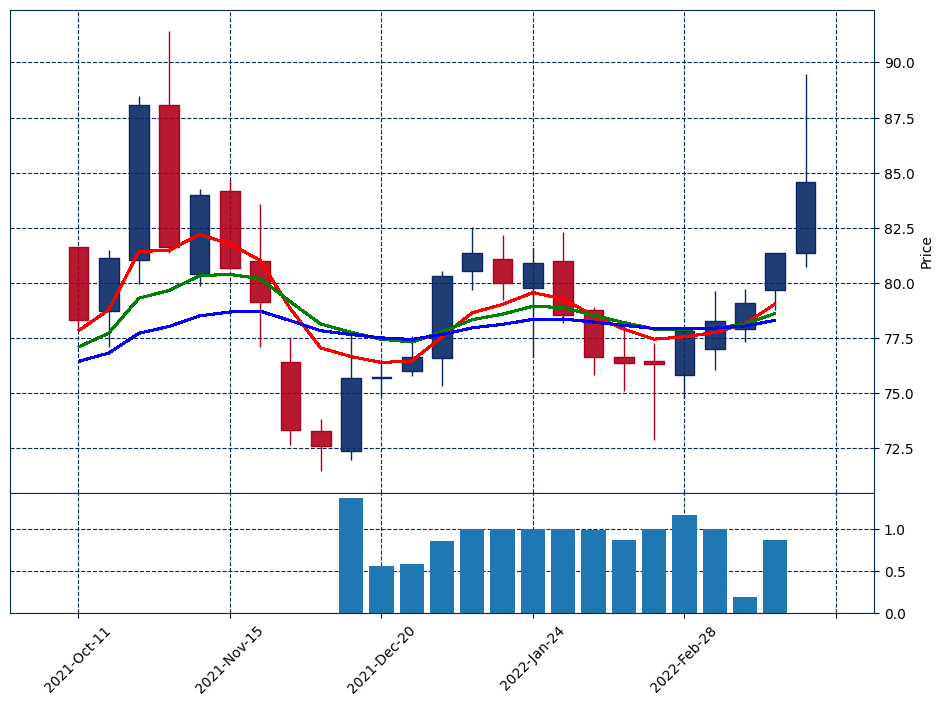

,Open,High,Low,Close,EMA6,EMA12,EMA24,labels,prediction,CombinedVaderSentiment,Datetime,profit,trade
In,,,,,,,,,,,,,
0,81.639999,81.639999,77.980003,78.330002,77.834209,77.100902,76.448361,nn,nn,0.00000,2021-10-11,7.42136,1
1,78.739998,81.480003,77.110001,81.150002,78.781578,77.723840,76.824492,nn,nn,0.00000,2021-10-18,7.42136,1
2,81.029999,88.459999,79.949997,88.050003,81.429699,79.312481,77.722533,nn,nn,0.00000,2021-10-25,7.42136,1
3,88.050003,91.400002,81.349998,81.610001,81.481214,79.665945,78.033530,nn,nn,0.00000,2021-11-01,7.42136,1
4,80.410004,84.260002,79.879997,84.000000,82.200867,80.332723,78.510848,nn,nn,0.00000,2021-11-08,7.42136,1
5,84.150002,84.690002,80.620003,80.699997,81.772047,80.389227,78.685980,nn,nn,0.00000,2021-11-15,7.42136,1
6,81.000000,83.589996,77.110001,79.160004,81.025749,80.200115,78.723902,nn,nn,0.00000,2021-11-22,7.42136,1
7,76.419998,77.500000,72.660004,73.339996,78.829820,79.144713,78.293189,nn,nn,0.00000,2021-11-29,7.42136,1
8,73.300003,73.849998,71.500000,72.620003,77.055586,78.140911,77.839334,nn,nn,0.00000,2021-12-06,7.42136,1


In [58]:
#trade = 4
from plotting import PlotTrade

df = PlotTrade(trade=trade,trades_df=trades_df,window_size=window_size,entry_candle=entry_candle,budget=budget,sentiment=sentiment)
trade += 1
df


In [59]:
from final_evaluation import GetPerformanceReport

GetPerformanceReport = GetPerformanceReport()

GetPerformanceReport.fit(entry_candle="Current Open",
                        budget=10000,
                        window_size=window_size,
                        export_excel=True,
                        excel_path = excel_reports)

trades_df_final = GetPerformanceReport.transform(trades_df)
trades_df_final


--------> GetPerformanceReport completed



,Open,High,Low,Close,EMA6,EMA12,EMA24,labels,prediction,CombinedVaderSentiment,Datetime,profit,trade,Entry,Performance
0,81.639999,81.639999,77.980003,78.330002,77.834209,77.100902,76.448361,nn,nn,0.00000,2021-10-11,7.421360,1,nn,nn
1,78.739998,81.480003,77.110001,81.150002,78.781578,77.723840,76.824492,nn,nn,0.00000,2021-10-18,7.421360,1,nn,nn
2,81.029999,88.459999,79.949997,88.050003,81.429699,79.312481,77.722533,nn,nn,0.00000,2021-10-25,7.421360,1,nn,nn
3,88.050003,91.400002,81.349998,81.610001,81.481214,79.665945,78.033530,nn,nn,0.00000,2021-11-01,7.421360,1,nn,nn
4,80.410004,84.260002,79.879997,84.000000,82.200867,80.332723,78.510848,nn,nn,0.00000,2021-11-08,7.421360,1,nn,nn
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
445,89.339996,90.019997,86.019997,87.410004,89.919787,89.663663,87.549877,nn,nn,0.90655,2022-08-01,-2.050003,18,nn,nn
446,87.300003,91.029999,86.809998,91.019997,90.234132,89.872330,87.827487,nn,nn,0.78005,2022-08-08,-2.050003,18,nn,nn
447,90.830002,93.019997,89.870003,92.080002,90.761524,90.211972,88.167688,nn,nn,0.99550,2022-08-15,-2.050003,18,nn,nn
448,91.809998,92.220001,89.070000,89.260002,90.332518,90.065515,88.255073,nn,nn,0.99000,2022-08-22,-2.050003,18,nn,nn


In [62]:
from final_evaluation import MakeSinglePrediction

model_name = f'{saved_models}/{str.upper(ticker)}_{formation_window}_{target_window}_{window_size}_{split_ratio}_{period}_{sentiment}_{start_date}_{end_date}.h5'

MakeSinglePrediction = MakeSinglePrediction()

fit_output = MakeSinglePrediction.fit(
                        model_name=model_name,
                        form_window=formation_window,
                        ticker=ticker,
                        start_date="2021-03-18",
                        end_date="2022-09-24",
                        interval='1wk',
                        progress=False,
                        condition=False,
                        timeperiod1=6,
                        timeperiod2=12,
                        timeperiod3=24,
                        debug=False,
                        budget=10000,
                        penalization=0,
                        acceptance=0,
                        entry_candle='Current Open',
                        news_df=news_df,
                        sentiment=sentiment,
                        sentiment_type = sentiment_type,
                        sentiment_aggr = aggr_function)

#fit method outputs tuple, get only trade formation out of tuple
trade_formation = fit_output[1]
final_trade_formation = trade_formation.head(24)
final_trade_formation
###IMPORTANT!!!!
#trade_formation dataframe must be checked before transformation, sometimes df pulled via yahoo finance 
# is shifted, and trade formation does not have entire formation in itself. in this case there must 
# be changed end_date in fit method
final_trade_formation


,Date,Open,High,Low,Close,EMA6,EMA12,EMA24,CombinedVaderSentiment
0,2022-04-04,83.500000,87.839996,82.730003,87.680000,82.432628,80.657608,79.405529,1.073374
1,2022-04-11,88.320000,89.480003,84.830002,86.910004,83.711878,81.619515,80.005887,0.566400
2,2022-04-18,86.419998,87.449997,84.500000,84.589996,83.962769,82.076512,80.372616,0.616908
3,2022-04-25,84.589996,90.010002,83.529999,88.690002,85.313407,83.093972,81.038007,0.589609
4,2022-05-02,88.720001,88.919998,86.360001,88.389999,86.192433,83.908746,81.626166,0.774300
5,2022-05-09,87.500000,91.050003,86.910004,90.410004,87.397453,84.908939,82.328873,0.138086
6,2022-05-16,90.790001,94.559998,90.680000,93.550003,89.155325,86.238334,83.226564,1.018028
7,2022-05-23,93.589996,94.919998,91.000000,93.080002,90.276661,87.290898,84.014839,0.609450
8,2022-05-30,91.910004,92.620003,88.739998,89.910004,90.171902,87.693837,84.486452,0.758306
9,2022-06-06,90.169998,90.820000,86.709999,87.180000,89.317073,87.614786,84.701936,0.360960



Ticker:  mrk
1/1 [==============================] - 2s 2s/step

Entry candle (Current Open)

Budget:  10000

Entry price:  88.13
Prediction:  91.8
Expected Market move:  3.67
Expected Profit:  415.26


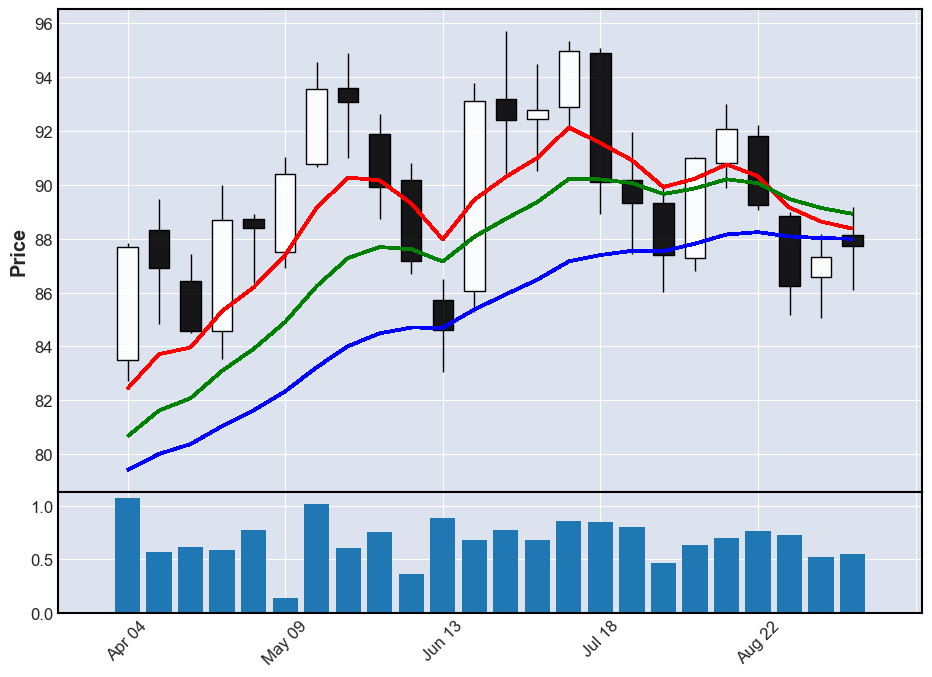

In [63]:
#Make prediction
MakeSinglePrediction.transform(final_trade_formation)

#PLot current chart and sentiment
from plotting import PlotCurrentFormation

PlotCurrentFormation(final_trade_formation,sentiment=sentiment)


<b>Record Predictions</b>

In [34]:
final_df = pd.DataFrame()
#List all predictions
dicti_prediction1 = {'ticker':['STNSE'],'Date':['21.8.2022'],'prediction':['12.97 (should be penalized by 2 - 10.97)'],'real market move':['pending'],'model':[""]}
dicti_prediction2 = {'ticker':['CLB'],'Date':['21.8.2022'],'prediction':['18.6'],'real market move':['succesful - 12.9.2022'],'model':[""]}
dicti_prediction3 = {'ticker':['MRK'],'Date':['27.8.2022'],'prediction':['93.23'],'real market move':['failed'],'model':[""]}
dicti_prediction4 = {'ticker':['CLB'],'Date':['04.9.2022'],'prediction':['18.08'],'real market move':['succesful - 9.9.2022'],'model':[model_name]}
dicti_prediction5 = {'ticker':['MRK'],'Date':['11.9.2022'],'prediction':['91.31'],'real market move':['pending'],'model':[model_name]}
dicti_prediction6 = {'ticker':['MRK'],'Date':['24.9.2022'],'prediction':['91.8'],'real market move':['pending'],'model':[model_name]}

trades_tuple = (dicti_prediction1,dicti_prediction2,dicti_prediction3,dicti_prediction4,dicti_prediction5,dicti_prediction6)
for item in trades_tuple:
    df_pred = pd.DataFrame(item)
    final_df = final_df.append(df_pred)
    final_df = final_df.sort_values('ticker',ascending=False)
final_df

,ticker,Date,prediction,real market move,model
0,STNSE,21.8.2022,12.97 (should be penalized by 2 - 10.97),pending,
0,MRK,27.8.2022,93.23,failed,
0,MRK,11.9.2022,91.31,pending,.\Saved models/MRK_24_4_25_0.8_1wk_True_2020-0...
0,MRK,24.9.2022,91.8,pending,.\Saved models/MRK_24_4_25_0.8_1wk_True_2020-0...
0,CLB,21.8.2022,18.6,succesful - 12.9.2022,
0,CLB,04.9.2022,18.08,succesful - 9.9.2022,.\Saved models/MRK_24_4_25_0.8_1wk_True_2020-0...
